## Import

In [9]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.nn.parameter import Parameter


from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

import copy

from cdd import CDD


In [10]:
# data import
df_s = pd.read_csv('df_s_concave_convex.csv')
df_s_true = pd.read_csv('df_s_true_concave_convex.csv')
df_t = pd.read_csv('df_t_concave_convex.csv')
df_t_true = pd.read_csv('df_t_true_concave_convex.csv')
df_t_labeled = pd.read_csv('df_t_labeled_true_concave_convex.csv')

In [11]:
# data preprocessing
x_s = torch.tensor(df_s['X']).reshape(-1,1).type(torch.float32)
x_t =torch.tensor(df_t['X']).reshape(-1,1).type(torch.float32)
x_t_labeled =torch.tensor(df_t_labeled['X']).reshape(-1,1).type(torch.float32)
y_s = torch.tensor(df_s['Y']).reshape(-1,1).type(torch.float32)
y_t =torch.tensor(df_t['Y']).reshape(-1,1).type(torch.float32)
y_t_labeled =torch.tensor(df_t_labeled['Y']).reshape(-1,1).type(torch.float32)
y_s_true = torch.tensor(df_s_true['Y']).reshape(-1,1).type(torch.float32)
y_t_true =torch.tensor(df_t_true['Y']).reshape(-1,1).type(torch.float32)

## DAR

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 40)
        self.relu = nn.ReLU()
        self.h2 = nn.Linear(40, 40)
        self.h4 = nn.Linear(40,40)
        self.reg = nn.Linear(40, 1)
        
        
        
    def forward(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h4(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.reg(h1_x)

        return h1_x
    
    def output(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h4(h1_x)
        f_x = self.relu(h1_x)
        y_hat = self.reg(h1_x)
        return {'f_x':f_x, 'output':y_hat}

### Pretrained

In [13]:
# model = Net()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# best_loss = 1000
# sample = random.sample(range(len(x_s)), len(x_s)*4//5)
# val_sample = list(set(range(len(x_s))) - set(sample))
# for epoch in range(10000):
#     model.train()
#     optimizer.zero_grad()
#     batch_sample = random.sample(sample, 30)
#     model_output_s = model.output(x_s[batch_sample])
#     latent_x_s = model_output_s['f_x']
#     y_s_hat = model_output_s['output']
#     y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s[batch_sample])
#     y_s_mse.backward()
#     optimizer.step()

#     model.eval()
#     model_output_s = model.output(x_s[val_sample])
#     latent_x_s = model_output_s['f_x']
#     y_s_hat = model_output_s['output']
#     val_loss = torch.nn.functional.mse_loss(y_s_hat, y_s[val_sample])
#     if best_loss > val_loss:
#         best_loss = val_loss
#         best_model = copy.deepcopy(model)
#         print(f"Saving... val mse{val_loss}")

# torch.save(best_model, "./best_pretrained_model_VC.pt")

### DA

In [14]:
# model = torch.load("./best_pretrained_model_VC.pt")
# model_output_s = model.output(x_s)
# latent_x_s = model_output_s['f_x']
# y_s_hat = model_output_s['output']

# model_output_t_labeled = model.output(x_t_labeled)
# latent_x_t_labeled = model_output_t_labeled['f_x']
# y_t_labeled_hat = model_output_t_labeled['output']

# model_output_t = model.output(x_t)
# latent_x_t = model_output_t['f_x']
# y_t_hat = model_output_t['output']

# # mse loss
# y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
# y_t_mse = torch.nn.functional.mse_loss(y_t_labeled_hat, y_t_labeled)
# y_t_real_mse = torch.nn.functional.mse_loss(y_t_hat, y_t_true)

# print(f"source mse : {y_s_mse}, labeled target mse : {y_t_mse}, target mse : {y_t_real_mse}")

In [15]:
class Mapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 10)
        self.relu = nn.ReLU()
        self.h2 = nn.Linear(10, 10)      
        self.reg = nn.Linear(10, 1)
        
    def forward(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.reg(h1_x)
        return h1_x
    
    def output(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        f_x = self.relu(h1_x)
        y_hat = self.reg(h1_x)
        return {'f_x':f_x, 'output':y_hat}

In [16]:
experiment_num = 5
darc_original_vc_result = []
darc_original_vc_result2 = []
epoch_total_num = 5000
bn_s = len(x_s)//5
loss_list = [[0 for i in range(epoch_total_num)] for j in range(experiment_num)]
for experiment_i in range(experiment_num):
    model = Net()
    optimizer_parent = optim.Adam(model.parameters(), lr=0.001)
    best_loss = 1000
    sample = random.sample(range(len(x_s)), len(x_s)*4//5)
    val_sample = list(set(range(len(x_s))) - set(sample))
    for epoch in range(10000):
        model.train()
        optimizer_parent.zero_grad()
        batch_sample = random.sample(sample, bn_s)
        model_output_s = model.output(x_s[batch_sample])
        latent_x_s = model_output_s['f_x']
        y_s_hat = model_output_s['output']
        y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s[batch_sample])
        y_s_mse.backward()
        optimizer_parent.step()

        model.eval()
        model_output_s = model.output(x_s[val_sample])
        latent_x_s = model_output_s['f_x']
        y_s_hat = model_output_s['output']
        val_loss = torch.nn.functional.mse_loss(y_s_hat, y_s[val_sample])
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = copy.deepcopy(model)
    model_output_s = model.output(x_s)
    latent_x_s = model_output_s['f_x']
    y_s_hat = model_output_s['output']

    y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s)
    y_s_true_mse = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
    darc_original_vc_result2.append([y_s_mse.detach().item(), y_s_true_mse.detach().item()])
    print(f"source mse : {y_s_mse.detach().item()}, denoise source mse : {y_s_true_mse.detach().item()}")
    pd.DataFrame(darc_original_vc_result2, columns=['TEST MSE', 'DENOISE TEST MSE']).to_csv('SOURCE_CV_RESULT.csv', index=0)
    model = copy.deepcopy(best_model)

    mapper = Mapper()
    optimizer = optim.Adam(mapper.parameters(), lr=0.001)
    bn = len(x_t_labeled)
    best_mapper = copy.deepcopy(mapper)
    best_loss = 1000

    for epoch in tqdm(range(epoch_total_num)):
        optimizer.zero_grad()
        mapper.train()
        latent_x_s = x_s
        mapper_output_t_labeled = mapper.output(x_t_labeled)
        latent_x_t_labeled = mapper_output_t_labeled['output']
        # source latent에서 batch 추출
        batch_latent_x_s_index = torch.randperm(latent_x_s.size(0))[:bn_s]
        batch_latent_x_s = latent_x_s[batch_latent_x_s_index]
        # cdd loss
        feats_toalign_S = [batch_latent_x_s, torch.tensor([1]).repeat(len(batch_latent_x_s),1)]
        feats_toalign_T = [latent_x_t_labeled, torch.tensor([1]).repeat(len(latent_x_t_labeled),1)]
        cdd = CDD(kernel_num=(10,10), kernel_mul=(2,2), num_layers=2, num_classes=1, intra_only=True)
        cdd_loss = cdd.forward(feats_toalign_S, feats_toalign_T, [bn_s], [bn])['cdd']
        # ns loss
        epsilon_k = 10
        f_s_vector = latent_x_s
        f_t_vector = latent_x_t_labeled
        from sklearn.neighbors import KNeighborsRegressor
        knn = KNeighborsRegressor(n_neighbors=epsilon_k)
        knn.fit(y_s, np.array(range(len(y_s))))
        total_ns_loss = 0
        for i in range(bn):
            best_dist = 1000
            error = 0
            neighbors = knn.kneighbors(y_t_labeled[i].reshape(-1,1))[1][0].tolist()
            for index_i in neighbors:
                temp_f_dist = torch.abs(f_t_vector[i] - f_s_vector[index_i]).norm()
                temp_y_dist = torch.abs(y_t_labeled[i] - y_s[index_i]).norm()
                if best_dist > temp_f_dist + temp_y_dist:
                    best_dist = temp_f_dist + temp_y_dist
                    error = temp_f_dist
            total_ns_loss += error
        ns_loss = total_ns_loss / bn

        total_loss = cdd_loss + ns_loss
        
        if best_loss > total_loss:
            best_loss = total_loss
            best_mapper = copy.deepcopy(mapper)
        total_loss.backward()
        optimizer.step()

        loss_list[experiment_i][epoch] = total_loss.detach().item()
    
    model_output_s = model.output(x_s)
    latent_x_s = model_output_s['f_x']
    y_s_hat = model_output_s['output']

    f_t = best_mapper.output(x_t)['output']
    model_output_t = model.output(f_t)
    latent_x_t = model_output_t['f_x']
    y_t_hat = model_output_t['output']


    # mse loss
    y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
    y_t_mse = torch.nn.functional.mse_loss(y_t_hat, y_t)
    y_t_true_mse = torch.nn.functional.mse_loss(y_t_hat, y_t_true)

    print(f"source mse : {y_s_mse}, target mse : {y_t_mse}, denoise mse : {y_t_true_mse}")    
    darc_original_vc_result.append([y_t_mse.detach().item(), y_t_true_mse.detach().item()])

    pd.DataFrame(y_t_hat.detach().numpy(), columns=['y_hat']).to_csv(f'DAR_CV_MODEL{experiment_i}.csv', index=0)
    pd.DataFrame(darc_original_vc_result, columns=['TEST MSE', 'DENOISE TEST MSE']).to_csv('DAR_CV_RESULT.csv', index=0)

source mse : 0.011269787326455116, denoise source mse : 0.00232753180898726


100%|██████████| 5000/5000 [03:02<00:00, 27.34it/s]


source mse : 0.0009978257585316896, target mse : 0.043836407363414764, denoise mse : 0.033755410462617874
source mse : 0.00969810038805008, denoise source mse : 0.0019079670310020447


100%|██████████| 5000/5000 [05:59<00:00, 13.90it/s]


source mse : 0.0018475191900506616, target mse : 0.13594579696655273, denoise mse : 0.12432605773210526
source mse : 0.011531442403793335, denoise source mse : 0.0030839527025818825


100%|██████████| 5000/5000 [02:50<00:00, 29.37it/s]


source mse : 0.002549454802647233, target mse : 0.03519636392593384, denoise mse : 0.025404103100299835
source mse : 0.010834201239049435, denoise source mse : 0.0028818813152611256


100%|██████████| 5000/5000 [02:48<00:00, 29.68it/s]


source mse : 0.001309843035414815, target mse : 0.04017408937215805, denoise mse : 0.0304782185703516
source mse : 0.012824191711843014, denoise source mse : 0.005913428030908108


100%|██████████| 5000/5000 [03:13<00:00, 25.78it/s]

source mse : 0.0019420807948336005, target mse : 0.03393590450286865, denoise mse : 0.023617854341864586


In [17]:
model_output_s = model.output(x_s)
latent_x_s = model_output_s['f_x']
y_s_hat = model_output_s['output']

f_t = best_mapper.output(x_t)['output']
model_output_t = model.output(f_t)
latent_x_t = model_output_t['f_x']
y_t_hat = model_output_t['output']


# mse loss
y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
y_t_mse = torch.nn.functional.mse_loss(y_t_hat, y_t)
y_t_true_mse = torch.nn.functional.mse_loss(y_t_hat, y_t_true)

print(f"source mse : {y_s_mse}, target mse : {y_t_mse}, denoise mse : {y_t_true_mse}")

source mse : 0.0019420807948336005, target mse : 0.03393590450286865, denoise mse : 0.023617854341864586


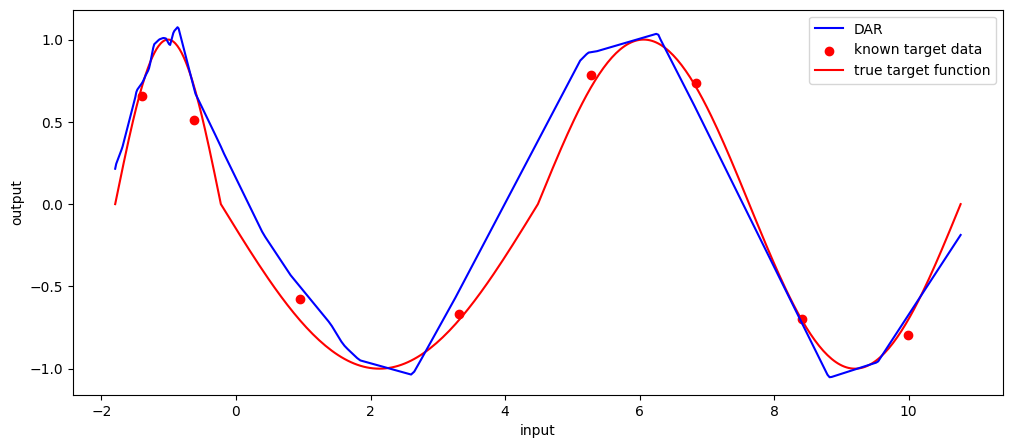

In [18]:
plt.figure(figsize=(12,5))
plt.plot(x_t, y_t_hat.detach().numpy(), c='blue', label='DAR', zorder=2)
plt.scatter(x_t_labeled, y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t, y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()